In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['face-place']


In [20]:
!unzip ../input/face-place/AsianSampleCategory.zip

Archive:  ../input/face-place/AsianSampleCategory.zip
replace train/AF0301/AF0301_1100_00F.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [21]:
from keras.models import Sequential, Model
from keras import layers
from keras.optimizers import Optimizer, Adam
from keras.models import Model
from keras.callbacks import History
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import codecs
import json

In [22]:
def train_model(model: Model, epochs: int):
    """Train vanilla cnn keras model.
    
    Args:
        model: Model, keras model
        epochs: int, training epochs
    Returns:
        model: Model, trained model
        history: History, keras history
    """
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    test_datagen = ImageDataGenerator(
        rescale=1. / 255,
        width_shift_range=0.2,
        height_shift_range=0.2)

    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        './train',
        target_size=(128, 128),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')
    validation_generator = test_datagen.flow_from_directory(
        './val',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

    # model = vanilla_cnn_keras(input_shape=input_shape, classes=classes)

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=50,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=50)

    return model, history


def plot_history(history: (History, dict)):
    """Plot history.
    
    Args:
        history: History or dict, model history to plot
    Returns:
        None
    """
    acc, val_acc, loss, val_loss = (history.history['acc'], history.history['val_acc'], 
                                    history.history['loss'], history.history['val_loss']
                                   ) if isinstance(history, History) else (
        history['acc'], history['val_acc'], history['loss'], history['val_loss'])
    
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'y', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'y', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    

def save_model(model: Model, history: History, name: str):
    """Save model and history in ../../models folder.
    
    Args:
        model: Model, trained model to save
        history: History, mdoel hisotry to save
        name: str, name for model and history
    Returns:
        None
    """
    model.save('./' + name + '.h5')
    with codecs.open('./' + name + '.json', 'w', 'utf-8') as f:
        json.dump(history.history, f, ensure_ascii=False)
        f.write('\n')

In [23]:
def identity_block(input_tensor, filters: int):
    """The identity block is the block that has no conv layer at shortcut.
    
    Args:
        input_tensor: input
        filters: int, filters
    Returns:
        x: output
    """
    x = layers.Conv2D(filters, 3, padding='same')(input_tensor)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=3)(x)
#     x = Activation('relu')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x


def conv_block(input_tensor, filters):
    """A block that has a conv layer at shortcut.
    
    Args:
        input_tensor: input
        filters: list, filters
    Returns:
        x: output
    """
    filter1, filter2 = filters

    x = layers.Conv2D(filter1, 3, padding='same')(input_tensor)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filter2, 3)(x)
    x = layers.BatchNormalization(axis=3)(x)

    shortcut = layers.Conv2D(filter2, 3)(input_tensor)
    shortcut = layers.BatchNormalization(axis=3)(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def resnet(input_shape: tuple=(128, 128, 3), classes: int=10, optimizer: (str, Optimizer)='adam'):
    """Resnet model.
    
    Args:
        input_shape: tuple, image shape, channel last, default (128, 128, 3)
        classes: int, image classes, default 10
        optimizer: str or Optimizer, optimizer to compile model, default adam
    Returns:
        model: Model, resnet model
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, 3, activation='relu', input_shape=input_shape)(inputs)
    x = identity_block(x, 16)
    x = layers.MaxPooling2D()(x)
#     x = Dropout(0.5)(x)
    x = conv_block(x, [16, 32])
    x = layers.MaxPooling2D()(x)
#     x = Dropout(0.5)(x)
    x = identity_block(x, 32)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(10, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
model = resnet(optimizer=Adam(lr=1e-4))
model.summary()

In [ ]:
model, history = train_model(model, 400)

In [ ]:
plot_history(history)

In [24]:
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.2,
    height_shift_range=0.2)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    './train',
    target_size=(128, 128),
    batch_size=32,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
    './val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

Found 236 images belonging to 10 classes.
Found 30 images belonging to 10 classes.


In [25]:
def reduced_resnet(input_shape: tuple=(128, 128, 3), classes: int=10, optimizer: (str, Optimizer)='adam'):
    """Resnet model.
    
    Args:
        input_shape: tuple, image shape, channel last, default (128, 128, 3)
        classes: int, image classes, default 10
        optimizer: str or Optimizer, optimizer to compile model, default adam
    Returns:
        model: Model, resnet model
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(8, 3, activation='relu', input_shape=input_shape)(inputs)
#     x = identity_block(x, 32)
    x = layers.MaxPooling2D()(x)
#     x = Dropout(0.5)(x)
    x = conv_block(x, [8, 8])
    x = layers.MaxPooling2D()(x)
#     x = Dropout(0.5)(x)
    x = identity_block(x, 8)
#     x = conv_block(x, [64, 128])
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(10, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [26]:
model = reduced_resnet(optimizer=Adam(lr=1e-4))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 126, 126, 8)  224         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 63, 63, 8)    0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 63, 63, 8)    584         max_pooling2d_8[0][0]            
__________________________________________________________________________________________________
batch_norm

In [ ]:
record = 0

0.800000011920929 0.7333333492279053
0.7333333492279053 0.6000000238418579
0.6000000238418579 0.699999988079071
0.699999988079071 0.800000011920929
0.800000011920929 0.699999988079071
0.699999988079071 0.8666666746139526
0.8666666746139526 0.699999988079071
0.699999988079071 0.6333333253860474
0.6333333253860474 0.800000011920929
0.800000011920929 0.8333333134651184
0.8333333134651184 0.7333333492279053
0.7333333492279053 0.800000011920929
0.800000011920929 0.5
big wave
train imgs


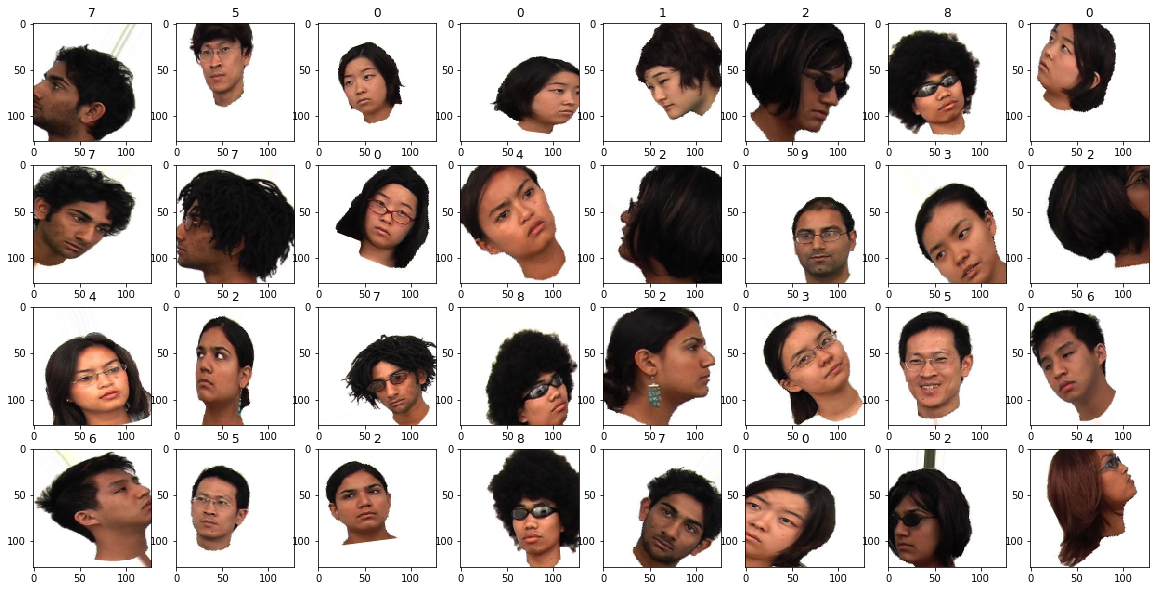

val imgs


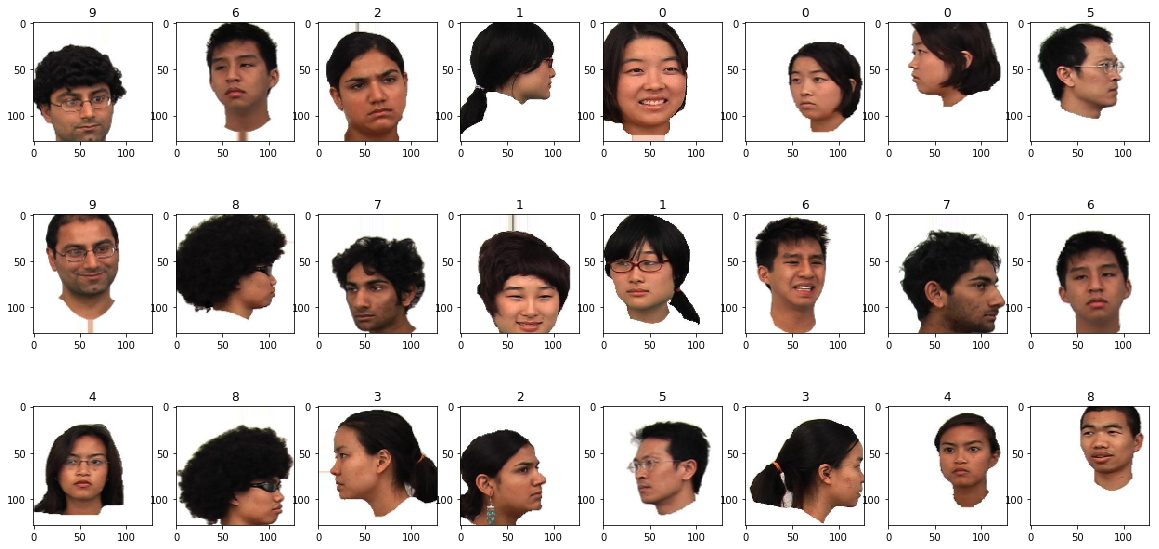

0.5 0.6000000238418579
0.6000000238418579 0.6333333253860474
0.6333333253860474 0.7666666507720947
0.7666666507720947 0.8333333134651184
0.8333333134651184 0.800000011920929
0.800000011920929 0.6666666865348816
0.6666666865348816 0.7666666507720947
0.7666666507720947 0.8333333134651184
0.8333333134651184 0.46666666865348816
big wave
train imgs


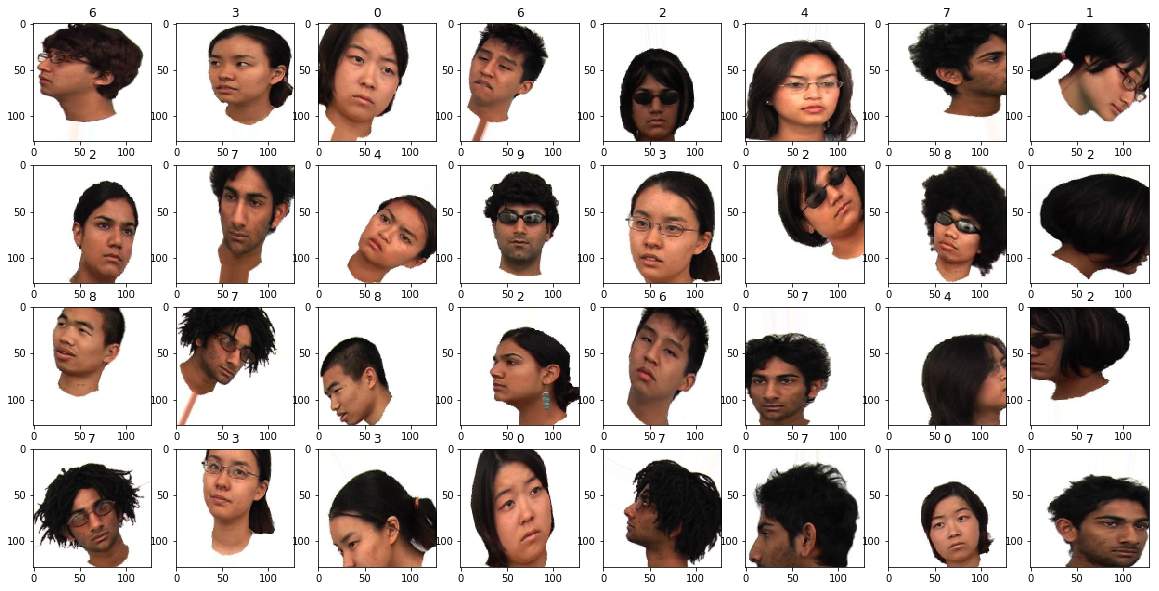

val imgs


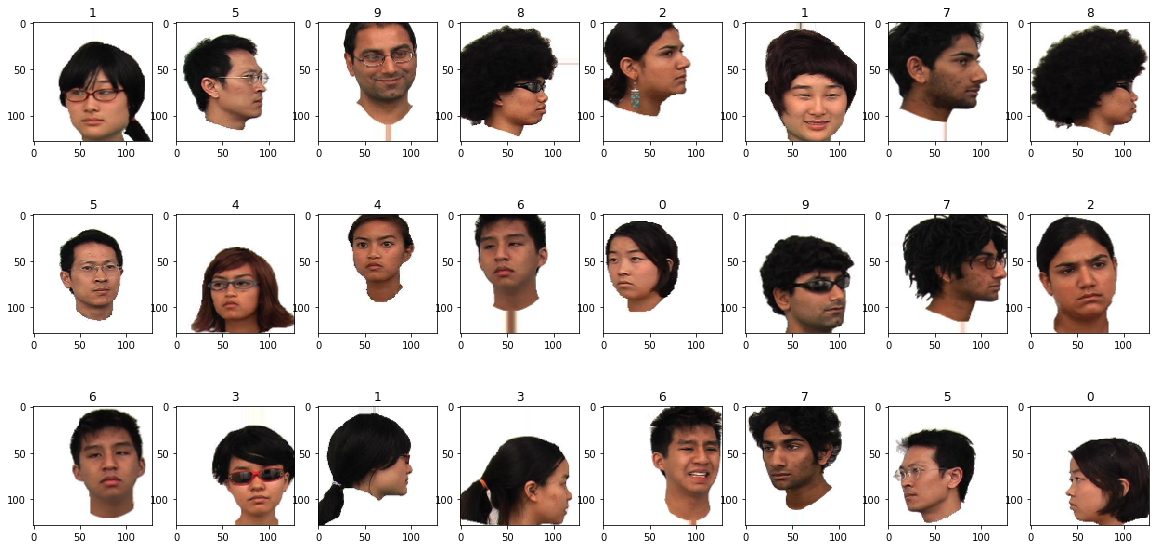

0.46666666865348816 0.8333333134651184
0.8333333134651184 0.7666666507720947
0.7666666507720947 0.7333333492279053
0.7333333492279053 0.800000011920929
0.800000011920929 0.6333333253860474
0.6333333253860474 0.8333333134651184
0.8333333134651184 0.5666666626930237
big wave
train imgs


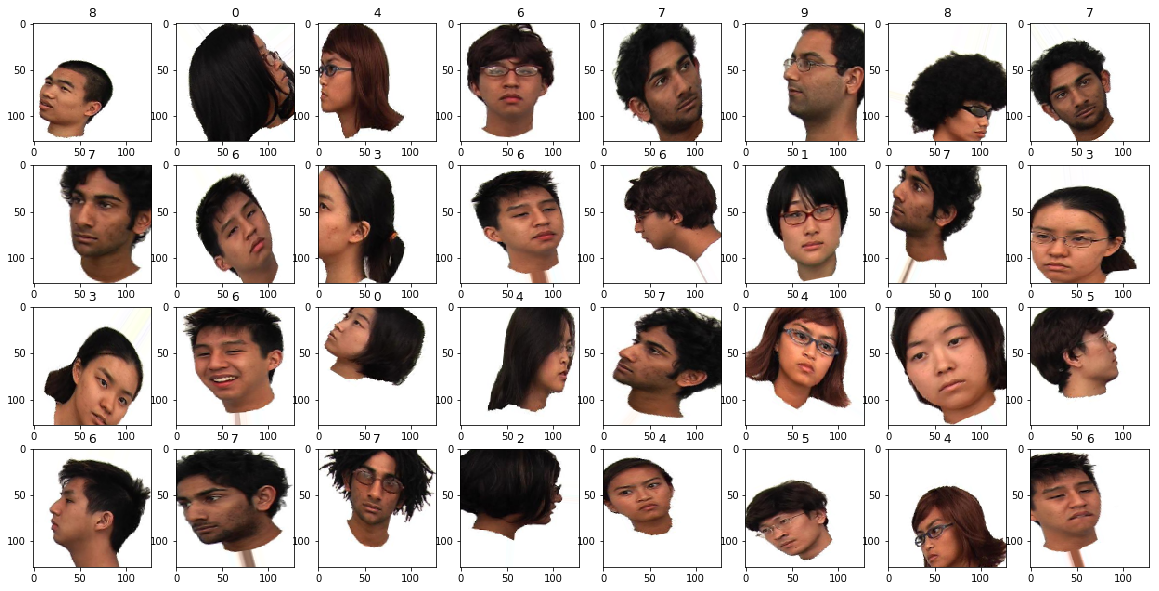

val imgs


In [ ]:
for i in range(50):
    x_batch, y_batch = train_generator.next()
    val_x_batch, val_y_batch = validation_generator.next()
    history = model.fit(x_batch, y_batch, validation_data=(val_x_batch, val_y_batch), epochs=50, verbose=0)
    print(record, history.history['val_acc'][-1])
    if record - history.history['val_acc'][-1] > 0.2:
        print('big wave')
        print('train imgs')
        img_per_row = 8
        fig, axarr = plt.subplots(x_batch.shape[0] // img_per_row, img_per_row, figsize=(20, 10))
        for i in range(x_batch.shape[0] // img_per_row):
            for j in range(img_per_row):
                axarr[i][j].imshow(x_batch[i * img_per_row + j])
                axarr[i][j].set_title(np.argmax(y_batch[i * img_per_row + j]))
        plt.show()
        print('val imgs')
        img_per_row = 8
        fig, axarr = plt.subplots(val_x_batch.shape[0] // img_per_row, img_per_row, figsize=(20, 10))
        for i in range(val_x_batch.shape[0] // img_per_row):
            for j in range(img_per_row):
                axarr[i][j].imshow(val_x_batch[i * img_per_row + j])     
                axarr[i][j].set_title(np.argmax(val_y_batch[i * img_per_row + j]))
        plt.show()
    record = history.history['val_acc'][-1]

# Count

label | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
:-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: 
train | 1 | 2 | 3 | 7 | 4 | 1 | 2 | 6 | 4 | 2
val | 2 | 3 | 2 | 3 | 3 | 3 | 3 | 2 | 2 | 1
train | 3 | 1 | 6 | 4 | 3 | 0 | 3 | 8 | 3 | 1
val | 2 | 3 | 2 | 2 | 2 | 3 | 3 | 3 | 2 | 2
train | 5 | 1 | 7 | 2 | 3 | 3 | 2 | 5 | 3 | 1
val | 3 | 3 | 2 | 2 | 2 | 2 | 3 | 2 | 3 | 2